In [7]:
# ==============================
# SuperKart Sales Prediction Model
# ==============================
# This script builds a machine learning model to predict
# product sales in retail stores using product and store attributes.


# ==============================
# Import required libraries
# ==============================

# Pandas: used for loading and manipulating tabular data (CSV files)
import pandas as pd

In [8]:
# NumPy: used for numerical operations and calculations
import numpy as np

In [9]:
# Matplotlib and Seaborn: used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Scikit-learn tools for data splitting, preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split        # Split data into train and test
from sklearn.compose import ColumnTransformer                # Apply different preprocessing to different columns
from sklearn.pipeline import Pipeline                        # Combine steps into a single workflow
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Scaling and encoding
from sklearn.impute import SimpleImputer                     # Handle missing values
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error  # Evaluation metrics

In [11]:
# XGBoost: advanced machine learning model for regression
from xgboost import XGBRegressor

In [12]:
# ==============================
# Step 1: Load Dataset
# ==============================

# Load the SuperKart dataset from a CSV file
df = pd.read_csv(r"D:\VictoriaUniversity\programming for data science\SuperKart.csv")

# Display dataset size (rows, columns) and first few records
print(df.shape)

(8763, 12)


In [13]:
print(df.head())

  Product_Id  Product_Weight Product_Sugar_Content  Product_Allocated_Area  \
0     FD6114           12.66             Low Sugar                   0.027   
1     FD7839           16.54             Low Sugar                   0.144   
2     FD5075           14.28               Regular                   0.031   
3     FD8233           12.10             Low Sugar                   0.112   
4     NC1180            9.57              No Sugar                   0.010   

         Product_Type  Product_MRP Store_Id  Store_Establishment_Year  \
0        Frozen Foods       117.08   OUT004                      2009   
1               Dairy       171.43   OUT003                      1999   
2              Canned       162.08   OUT001                      1987   
3        Baking Goods       186.31   OUT001                      1987   
4  Health and Hygiene       123.67   OUT002                      1998   

  Store_Size Store_Location_City_Type          Store_Type  \
0     Medium                   

In [14]:

# Target variable:
# This is the value we want the model to predict (total product sales)

y = df["Product_Store_Sales_Total"]

In [15]:
# Feature variables:
# These are all other columns used to predict sales
#Remove the sales column from the dataset so that it is not used as an input to the model.
##if its not removed, The model would see the answer during training,This would cause data leakage and invalid results
X = df.drop("Product_Store_Sales_Total", axis=1)

In [16]:
df.head()

,Product_Id,Product_Weight,Product_Sugar_Content,Product_Allocated_Area,Product_Type,Product_MRP,Store_Id,Store_Establishment_Year,Store_Size,Store_Location_City_Type,Store_Type,Product_Store_Sales_Total
0,FD6114,12.66,Low Sugar,0.027,Frozen Foods,117.08,OUT004,2009,Medium,Tier 2,Supermarket Type2,2842.40
1,FD7839,16.54,Low Sugar,0.144,Dairy,171.43,OUT003,1999,Medium,Tier 1,Departmental Store,4830.02
2,FD5075,14.28,Regular,0.031,Canned,162.08,OUT001,1987,High,Tier 2,Supermarket Type1,4130.16
3,FD8233,12.10,Low Sugar,0.112,Baking Goods,186.31,OUT001,1987,High,Tier 2,Supermarket Type1,4132.18
4,NC1180,9.57,No Sugar,0.010,Health and Hygiene,123.67,OUT002,1998,Small,Tier 3,Food Mart,2279.36


In [18]:
# ==============================
# Step 3: Identify Feature Types
# ==============================
# Select numerical features (numbers such as price, weight, shelf area)
# Get names of numeric columns
# num_features is variable name that stores numeric column names (like price, weight, shelf_area)
num_features = X.select_dtypes(include=["int64", "float64"]).columns

In [19]:
# Select categorical features (text values such as store type, city type)
cat_features = X.select_dtypes(include=["object"]).columns

In [20]:
# ==============================
# Step 4: Data Preprocessing Pipelines
# ==============================

# Numerical preprocessing pipeline:
# 1. Replace missing values with the median
# 2. Scale values so they are on the same range
# From sklearn.pipeline: numeric pipeline → fill missing values with median(median isn’t skewed by outliers), then standardize features
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [21]:
# Categorical preprocessing pipeline:
# 1. Replace missing values with the most common category
# 2. Convert text categories into numeric format using one-hot encoding
#SimpleImputer(strategy="most_frequent") fills in missing values in categorical (text) columns.
#OneHotEncoder(handle_unknown="ignore") converts categorical values into numeric form by creating binary columns (one per category).
# From sklearn.pipeline: categorical pipeline → fill missing values with most frequent, then one-hot encode
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [22]:

# Combine numerical and categorical preprocessing into one step
# From sklearn.compose: apply numeric and categorical pipelines to their respective columns
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

In [23]:
# ==============================
# Step 5: Split Data into Training and Testing Sets
# ==============================

# Split the data:
#train_test_split: Comes from sklearn.model_selection. It splits your dataset into two parts: training and testing
#X →  features (independent variables).
#y → target (dependent variable).
# - 70% for training the model
# - 30% for testing the model on unseen data
#random_state=42 ensures that the data is split in the same way every time the code is run, so the results can be reproduced and verified.any number can be used
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [24]:
# ==============================
# Step 6: Define the Machine Learning Model
# ==============================

# XGBoost Regressor:
# A powerful tree-based model suitable for structured retail data
#XGBRegressor: Comes from the xgboost library. It’s a gradient boosting model designed for regression tasks (predicting continuous values).
# n_estimators=500 → build 500 trees (needed because learning_rate is small, ensures enough boosting rounds)
#max_depth=6 → Maximum depth of each tree. Controls how complex each tree can be. Deeper trees can capture more patterns but may overfit
#Overfit (model memorizes training data, fails on new data).

xgb_model = XGBRegressor(
    n_estimators=500,      # Number of trees
    learning_rate=0.05,    # Controls how fast the model learns
    max_depth=6,           # Controls model complexity
    random_state=42
)

In [25]:
# Combine preprocessing and model into a single pipeline
# Full pipeline: preprocess features (numeric + categorical) then train XGBoost regression model
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_model)
])


In [27]:

# ==============================
# Step 7: Train the Model
# ==============================

# Train the model using the training data
# Step 1: Preprocess training data # - Numeric features → impute missing values with median, then scale 
# - Categorical features → impute missing values with most frequent, then one-hot encode 
# Step 2: Fit the model
# - Pass the cleaned data to XGBRegressor 
# - Model learns the relationship between features (X_train) and target (y_train)
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [28]:
# ==============================
# Step 8: Make Predictions
# ==============================

# Predict sales values for the test dataset
# Predict on test data: preprocess X_test then generate target predictions with trained XGBRegressor
# XGBRegressor → gradient boosting model for regression (predicts continuous values, handles complex patterns well)
y_pred = model_pipeline.predict(X_test)

In [29]:
# To see the predictions: print(y_pred[:10]) # show first 10 predicted values
print(y_pred[:10])

[3432.773  3366.9424 2468.9126 1916.2693 4660.828  2859.822  2857.9258
 3153.163  3255.7373 1587.5048]


In [30]:
# ==============================
# Step 9: Evaluate Model Performance
# ==============================

# R² (Coefficient of Determination):a common regression metric.Comes from sklearn.metrics.
# Measures how much of the variation in sales is explained by the model
#Measures how well  predictions (y_pred) match the actual values (y_test).
#interpretation of R²
#1.0 =  (perfect fit).
#Around 0.7–0.9 = good fit.
#Near 0 = poor fit.
#Negative → model performs worse than a simple mean baseline.
# Evaluate model with R² score → measures how well predictions (y_pred) match actual values (y_test)
r2 = r2_score(y_test, y_pred)

In [31]:
# MAE (Mean Absolute Error):
# Average absolute difference between predicted and actual sales
#Measures the average absolute difference between predicted values (y_pred) and actual values (y_test)
#Lower MAE = better performance.
mae = mean_absolute_error(y_test, y_pred)

In [32]:
# RMSE (Root Mean Squared Error):
# Penalizes larger prediction errors more heavily
#Lower RMSE = better model performance.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [33]:
# Display evaluation results
print("Model Evaluation Results:")

Model Evaluation Results:


In [34]:
print(f"R² Score: {r2:.4f}")

R² Score: 0.9277


In [35]:
print(f"MAE: {mae:.2f}")

MAE: 119.78


In [36]:
print(f"RMSE: {rmse:.2f}")

RMSE: 286.44


<Axes: xlabel='Product_Store_Sales_Total'>

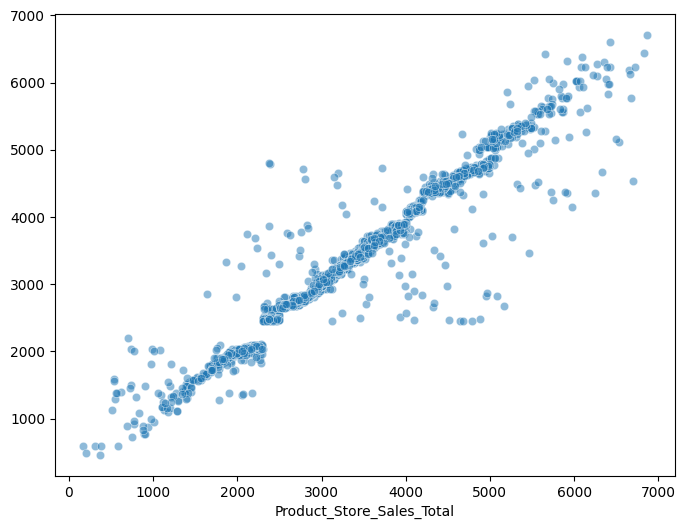

In [37]:
# ==============================
# Step 10: Visualization (Optional)
# ==============================

# Scatter plot comparing actual vs predicted sales
#X‑axis: actual sales values (y_test).
#Y‑axis: predicted sales values (y_pred).
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

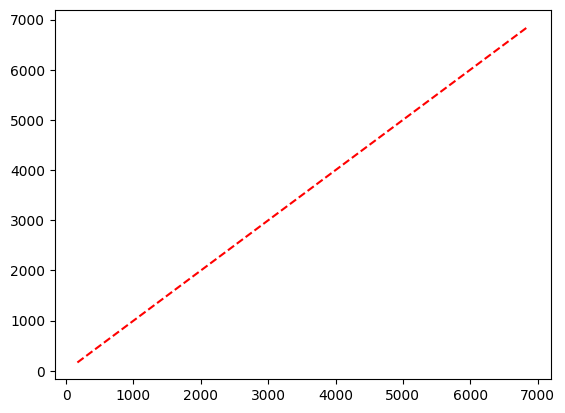

In [38]:
# Reference line (perfect prediction line)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--",
    color="red"
)


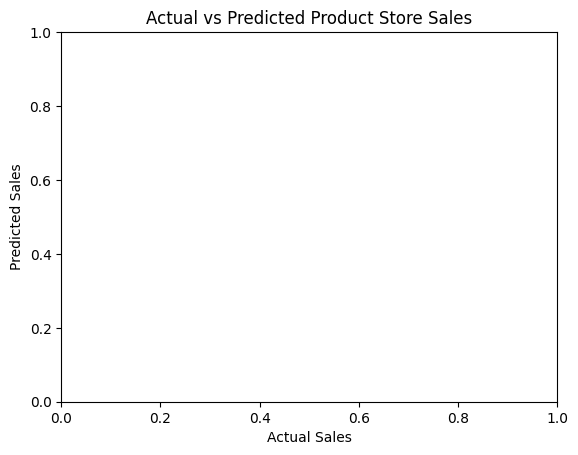

In [39]:
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Product Store Sales")
plt.show()


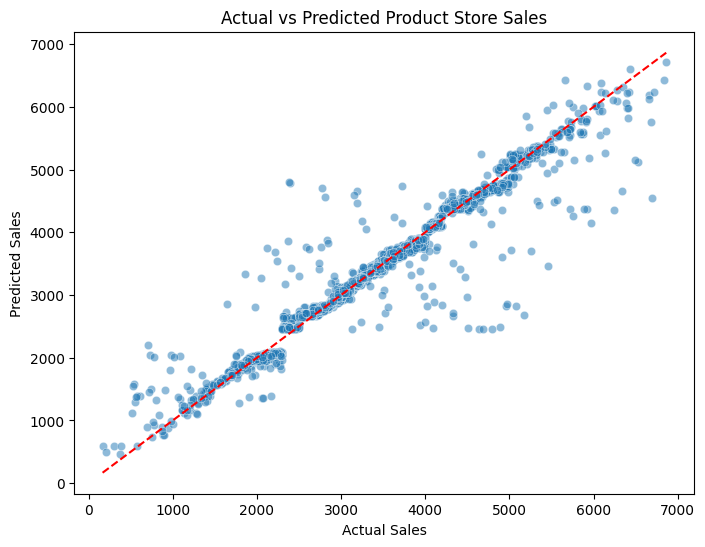

In [40]:
# ==============================
# Step 10: Visualization (Optional)
# ==============================

# Scatter plot comparing actual vs predicted sales
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

# Reference line (perfect prediction line)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--",
    color="red"
)

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Product Store Sales")
plt.show()
